# Geopandas library

## Config

In [1]:
from matplotlib.animation import FuncAnimation

import contextily as cx
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys

# Move two levels up (to the project root) and append the `src` folder
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Append src to sys.path
sys.path.append(src_path)

from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

# Dataset

In [2]:
START_DATE = "'2024-07-01'"
END_DATE = "'2024-07-01'"
COUNTRY = "'ES'"


params = [
    {'name':'start_date', 'value': START_DATE},
    {'name':'end_date', 'value': END_DATE},
    {'name':'country', 'value': COUNTRY}]

#cart_loaded
q.prepare_query(query_file='orders.sql', params=params, to_load_file='orders', load_from_to_load_file='orders')

orders = q.query_run_starburst()

# Geospatial map using coordinates

In [3]:
# Filtering only for Canary Islands
islands = orders.copy()

islands = islands[islands['latitude'] < 30]
islands = islands[islands['latitude'] > 28.8]
islands = islands[islands['longitude'] > -15]

islands.head()

,order_id,order_created_at,order_city_code,point_id,latitude,longitude
84,100706673319,2024-07-01 21:06:37+00:00,ARF,05d7692ef0a340e00b83f3f691eeed9d4629096731aa1a...,28.977900,-13.566970
148,100705787246,2024-07-01 15:33:15+00:00,ARF,102542ce6f26b0bff5a802fd1e923b70897954a5a6494c...,28.972913,-13.562420
977,100706644511,2024-07-01 20:48:54+00:00,ARF,4c2e7403a7673e5a434468abc5d0c51f8595d3eea182b2...,28.956716,-13.587360
1014,100706700580,2024-07-01 21:28:01+00:00,ARF,5b626406ba6cc674b0ab4b70abc7bc3cd0a26f6bd55cc3...,28.966297,-13.547994
1627,100705554420,2024-07-01 13:41:55+00:00,ARF,b3f43c55763aad76194d3e9f96f3c90902352fb386461b...,28.956716,-13.587360


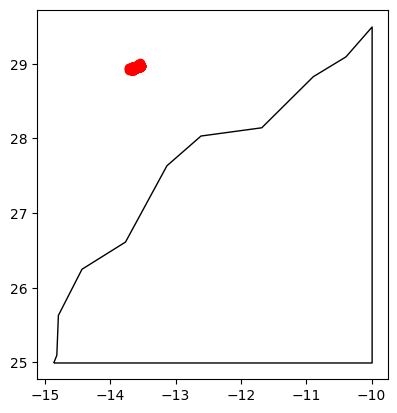

In [4]:
gdf = gpd.GeoDataFrame(
    islands, geometry=gpd.points_from_xy(islands.longitude, islands.latitude), crs="EPSG:4326"
)

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# We restrict to Barcelona
ax = world.clip([-16, 25, -10, 32]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

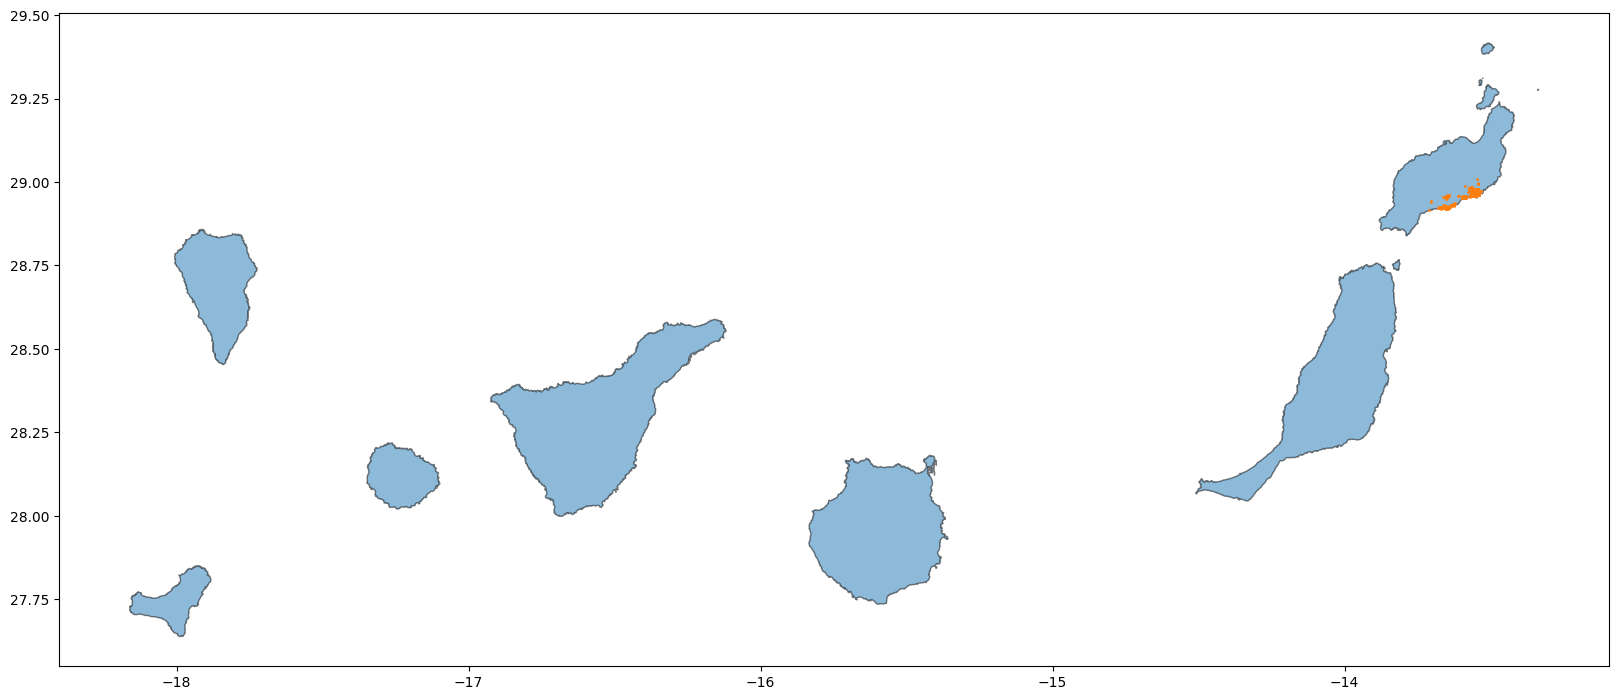

In [5]:
# Load Canary Islands shapefile (replace with your actual file path)
canary_islands = gpd.read_file("maps/islas_20170101_generalizada")

# Plot the Canary Islands, similar to what you did with NYC
ax = canary_islands.plot(figsize=(20, 10), alpha=0.5, edgecolor='k')

# Plot your orders or other GeoDataFrame
gdf.plot(ax=ax, color="#ff7f0e", markersize = 1)

plt.show()

# A movie

/var/folders/sx/jzncyhtx3x57mszpcz2rnzmw0000gn/T/ipykernel_28940/1496374554.py:41: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start="00:00", end="23:59", freq=f'{interval_minutes}T').time
MovieWriter imagemagick unavailable; using Pillow instead.


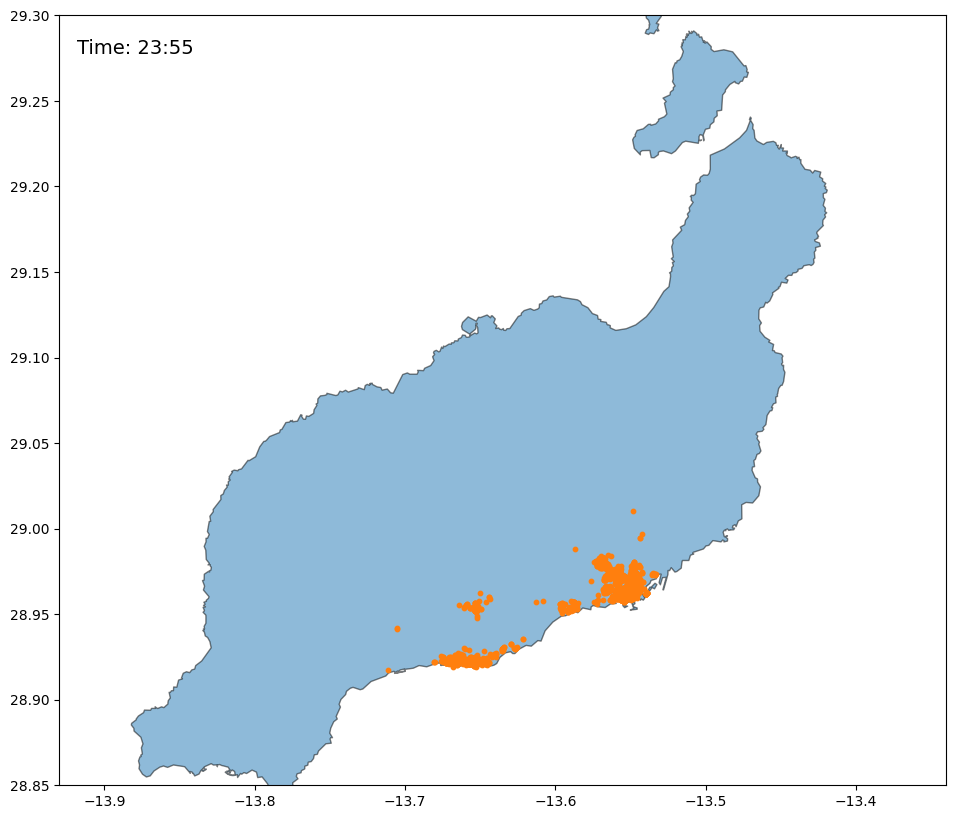

In [12]:
INTERVAL_MINUTES = 5

# Load Canary Islands shapefile
canary_islands = gpd.read_file("maps/islas_20170101_generalizada")

# Ensure 'order_created_at' is in datetime format and is timezone naive
islands['order_created_at'] = pd.to_datetime(islands['order_created_at']).dt.tz_localize(None)  # Make tz-naive

# Sort by 'order_created_at'
islands = islands.sort_values('order_created_at')

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    islands, geometry=gpd.points_from_xy(islands.longitude, islands.latitude), crs="EPSG:4326"
)

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the Canary Islands base map
canary_islands.plot(ax=ax, alpha=0.5, edgecolor='k')

# Focus the plot on Lanzarote by setting the x and y limits (bounding box)
plt.xlim([-13.93, -13.34])  # Longitude range for Lanzarote
plt.ylim([28.85, 29.30])    # Latitude range for Lanzarote

# Initialize an empty scatter plot
scat = ax.scatter([], [], color="#ff7f0e", s=10)  # Adjust the size of points here

# Initialize a text element that will display the current timestamp
timestamp_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=14, color='black')

# Define the start and end time for the day (e.g., 00:00 to 23:59)
start_time = pd.Timestamp("00:00").time()
end_time = pd.Timestamp("23:59").time()

# Set the time interval in minutes (customize this value)
interval_minutes = INTERVAL_MINUTES  # e.g., every 5 minutes

# Generate the timestamps from 00:00 to 23:59 with the chosen interval
timestamps = pd.date_range(start="00:00", end="23:59", freq=f'{interval_minutes}T').time

# Function to update the scatter plot and the timestamp for each frame
def update(frame):
    # Create a full datetime for each timestamp, assume it's from the first day of data
    day = islands['order_created_at'].min().date()
    current_time = pd.Timestamp.combine(day, frame)

    # Make sure current_time is timezone-naive, as is 'order_created_at'
    current_orders = gdf[gdf['order_created_at'] <= current_time]

    # Update the scatter plot with new data points
    scat.set_offsets(current_orders[['longitude', 'latitude']].values)
    
    # Update the timestamp text
    timestamp_text.set_text(f"Time: {frame.strftime('%H:%M')}")
    
    return scat, timestamp_text

# Create the animation
ani = FuncAnimation(fig, update, frames=timestamps, repeat=False, interval=100)  # interval is in milliseconds

# Save the animation as an MP4 file
ani.save("outputs/lanzarote_orders.gif", writer='imagemagick', dpi=300)  # Save as GIF with high resolution

plt.show()